In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
from matplotlib.cm import viridis
import seaborn as sns
from matplotlib.colors import Normalize

In [3]:
# 현재 작업 디렉토리 경로 얻기
current_directory = os.getcwd()
# 나눔바른고딕 글꼴 파일 경로 지정
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

# 글꼴이 있는지 확인
if os.path.exists(font_path):
    # 폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 출력 설정

In [4]:
kakao = pd.read_csv('dfkakao.csv')

C:\Users\tkdeh\AppData\Local\Temp\ipykernel_26064\1375103004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2023['keywords_list'] = data_2023['keywords'].apply(extract_keywords)


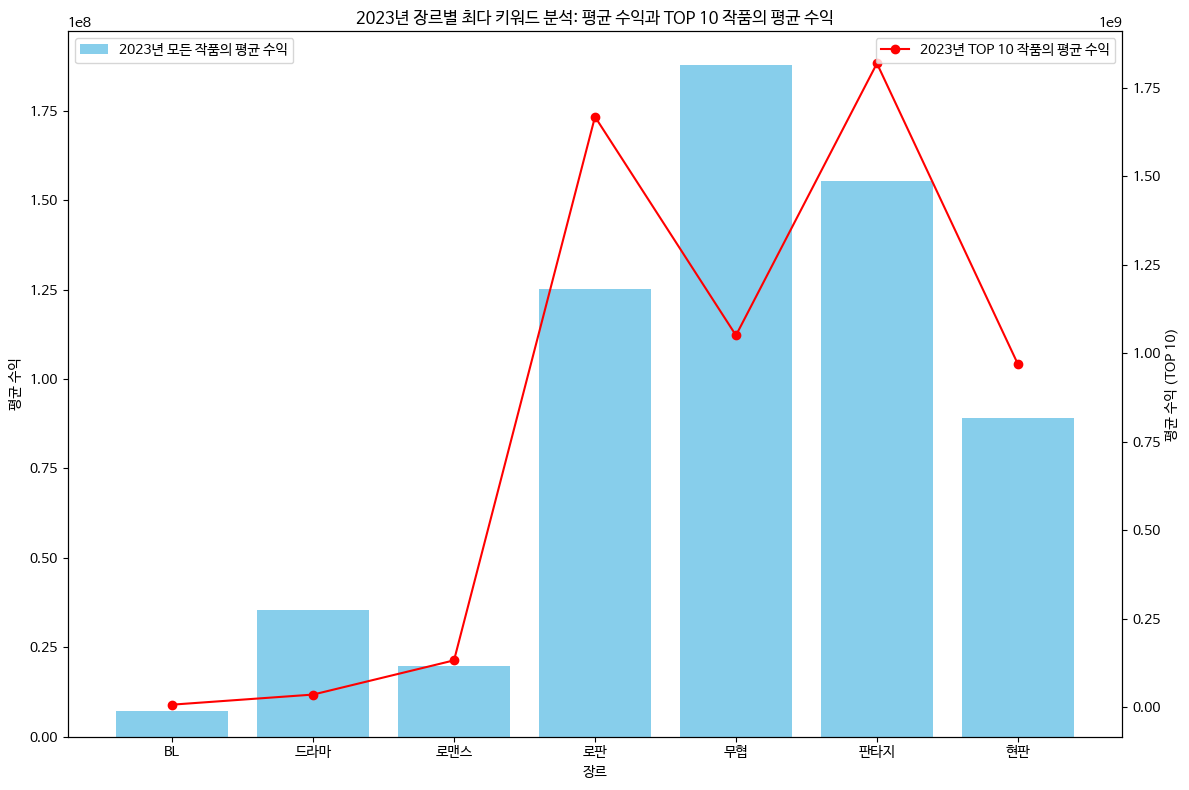

In [19]:
# 데이터 로드 및 전처리
kakao['date'] = pd.to_datetime(kakao['date'])
data_2023 = kakao[kakao['date'].dt.year == 2023]

# 각 작품의 키워드를 리스트 형태로 변환
def extract_keywords(row):
    return row.split('#')[1:]

data_2023['keywords_list'] = data_2023['keywords'].apply(extract_keywords)

# 장르별로 가장 많이 등장한 키워드 찾기
genre_keywords = data_2023.explode('keywords_list').groupby(['genre', 'keywords_list']).size().reset_index(name='count')
top_keywords = genre_keywords.loc[genre_keywords.groupby('genre')['count'].idxmax()][['genre', 'keywords_list']]

# 원본 데이터와 병합하여 최다 키워드를 포함하는 작품 필터링
top_keywords_merged = pd.merge(data_2023, top_keywords, left_on='genre', right_on='genre')

# 각 작품이 최다 키워드를 포함하는지 확인하여 필터링
top_keywords_merged = top_keywords_merged[top_keywords_merged.apply(lambda x: x['keywords_list_y'] in x['keywords_list_x'], axis=1)]

# 장르별로 '올해의 키워드'를 포함하면서 date가 2023년인 모든 작품의 평균 수익
average_sales_2023 = top_keywords_merged.groupby(['genre', 'keywords_list_y'])['sales'].mean().reset_index()

# 장르별로 '올해의 키워드'를 포함하면서 date가 2023년인 작품 중에서 sales가 가장 높은 TOP 10 작품의 평균 수익
top_sales_2023 = top_keywords_merged.groupby(['genre', 'keywords_list_y']).apply(lambda x: x.nlargest(10, 'sales')).reset_index(drop=True)
top_average_sales_2023 = top_sales_2023.groupby(['genre', 'keywords_list_y'])['sales'].mean().reset_index()

# 장르별로 '올해의 키워드'를 포함하면서 date가 2023년인 모든 작품의 평균 수익
average_sales_2023 = top_keywords_merged.groupby(['genre', 'keywords_list_y'])['sales'].mean().reset_index()

# 장르별로 '올해의 키워드'를 포함하면서 date가 2023년인 작품 중에서 sales가 가장 높은 TOP 10 작품의 평균 수익
top_sales_2023 = top_keywords_merged.groupby(['genre', 'keywords_list_y']).apply(lambda x: x.nlargest(10, 'sales')).reset_index(drop=True)
top_average_sales_2023 = top_sales_2023.groupby(['genre', 'keywords_list_y'])['sales'].mean().reset_index()

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(12, 8))

# 막대 그래프: 2023년 모든 작품의 평균 수익
ax1.bar(average_sales_2023['genre'], average_sales_2023['sales'], color='skyblue', label='2023년 모든 작품의 평균 수익')
ax1.set_xlabel('장르')
ax1.set_ylabel('평균 수익')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

# 선 그래프: 2023년 TOP 10 작품의 평균 수익
ax2 = ax1.twinx()
ax2.plot(top_average_sales_2023['genre'], top_average_sales_2023['sales'], color='red', marker='o', label='2023년 TOP 10 작품의 평균 수익')
ax2.set_ylabel('평균 수익 (TOP 10)')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

# 그래프 설정
plt.title('2023년 장르별 최다 키워드 분석: 평균 수익과 TOP 10 작품의 평균 수익')
plt.xticks(rotation=45)
plt.tight_layout()

# 그래프 출력
plt.show()

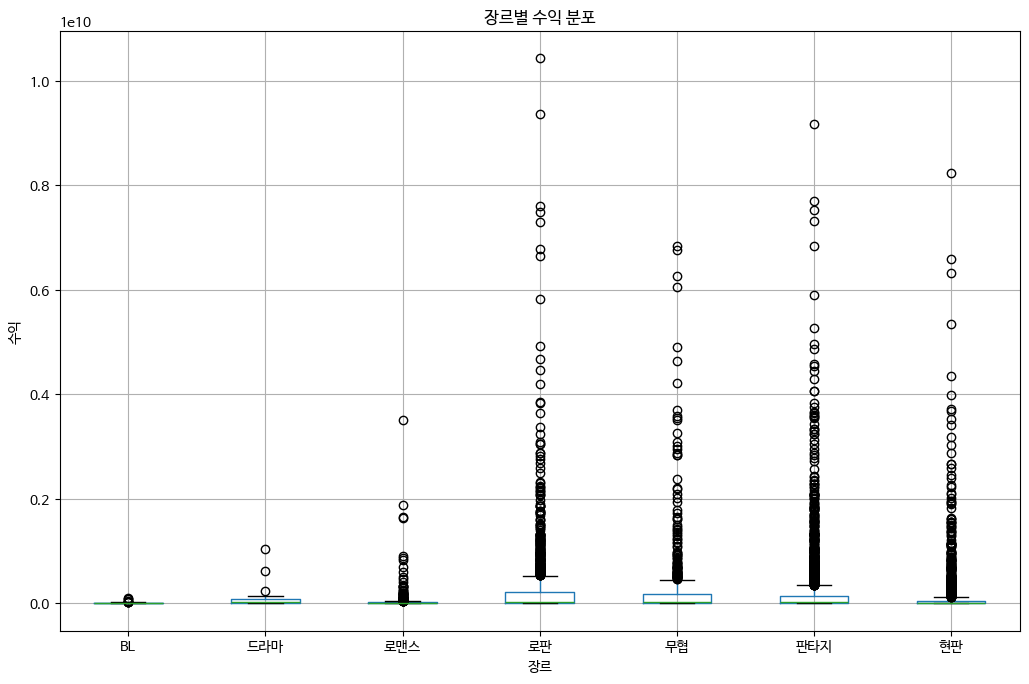

In [21]:
# 장르별로 수익 분포를 box plot으로 시각화
fig, ax = plt.subplots(figsize=(12, 8))
kakao.boxplot(column='sales', by='genre', ax=ax)
ax.set_title('장르별 수익 분포')
ax.set_xlabel('장르')
ax.set_ylabel('수익')
plt.suptitle('')
plt.show()


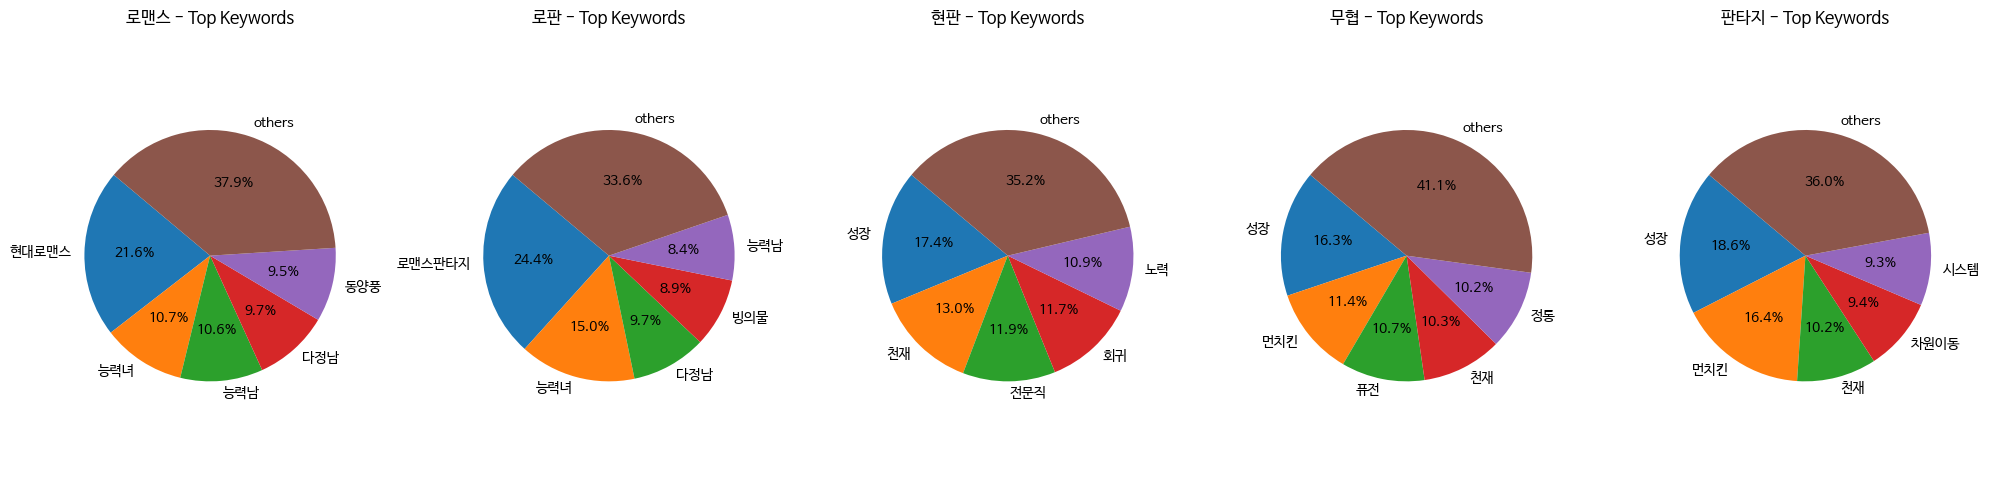

In [25]:
# 'date' 컬럼을 datetime 형식으로 변환하고 연도 컬럼 추가
kakao['date'] = pd.to_datetime(kakao['date'])
kakao['year'] = kakao['date'].dt.year

# 장르 목록
genres = ['로맨스', '로판', '현판', '무협', '판타지']

# 장르별 키워드 빈도 계산
genre_keyword_freq = {genre: Counter() for genre in genres}

for index, row in kakao.iterrows():
    genre = row['genre']
    if genre in genres:
        keywords = row['keywords'].split('#')[1:]  # '#'로 분할 후 첫 번째 요소는 제외
        genre_keyword_freq[genre].update(keywords)

# 파이차트 그리기
fig, axes = plt.subplots(1, len(genres), figsize=(20, 5))

for i, genre in enumerate(genres):
    counter = genre_keyword_freq[genre]
    most_common = counter.most_common(10)
    
    # 상위 5개와 6~10번째 키워드를 others로 합침
    labels = [keyword for keyword, _ in most_common[:5]]
    sizes = [freq for _, freq in most_common[:5]]
    others_count = sum(freq for _, freq in most_common[5:10])
    
    if others_count > 0:
        labels.append('others')
        sizes.append(others_count)
    
    axes[i].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    axes[i].axis('equal')
    axes[i].set_title(f'{genre} - Top Keywords')

plt.tight_layout()
plt.show()


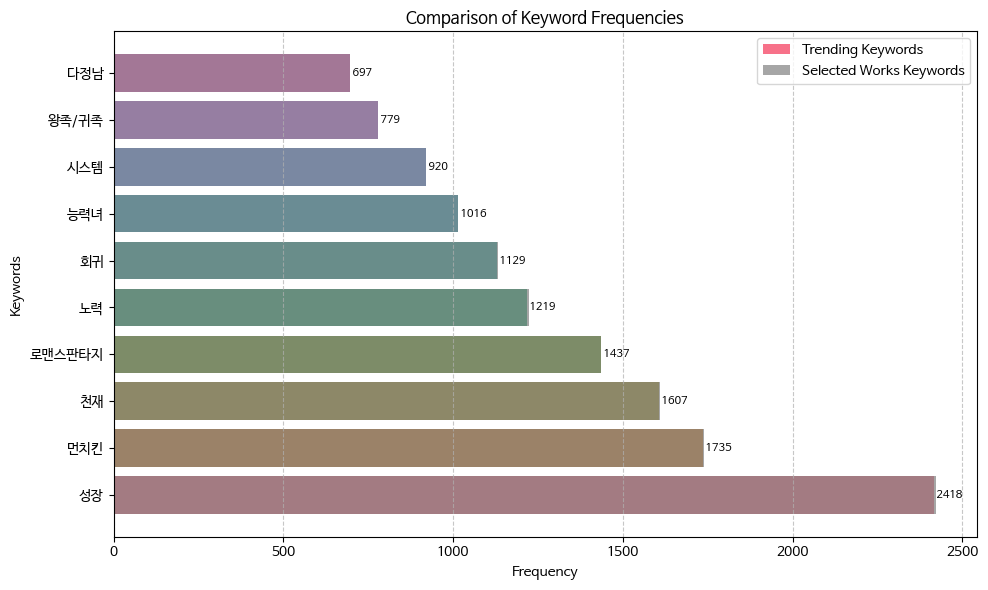

In [28]:
kakao['date'] = pd.to_datetime(kakao['date'])
kakao['year'] = kakao['date'].dt.year

start_year = 2014
end_year = 2024

# 유행 시대 동안의 키워드 빈도 계산
trending_keywords = Counter()
for index, row in kakao.iterrows():
    if start_year <= row['year'] <= end_year:
        keywords = row['keywords'].split('#')[1:]
        trending_keywords.update(keywords)

# 가장 많이 등장한 10개의 키워드 선택
top_trending_keywords = [keyword for keyword, _ in trending_keywords.most_common(10)]

# 선택된 작품들의 키워드 빈도 계산
selected_works = kakao['title']

selected_keywords = Counter()
for work in selected_works:
  work_data = kakao[kakao['title'] == work]
  for index, row in work_data.iterrows():
    keywords = row['keywords'].split('#')[1:]
    selected_keywords.update(keywords)

# 비교 데이터 준비
trending_data = [trending_keywords[keyword] for keyword in top_trending_keywords]
selected_data = [selected_keywords[keyword] for keyword in top_trending_keywords]

# 팔레트 설정 (다양한 색상 적용)
palette = sns.color_palette("husl", len(top_trending_keywords))
norm = Normalize(min(trending_data), max(trending_data))
colors = palette

# 그래프 그리기
plt.figure(figsize=(10, 6))

# Trending Keywords 그래프 그리기
bars1 = plt.barh(top_trending_keywords, trending_data, color=colors, label='Trending Keywords')

# Selected Works Keywords 그래프 추가 설정
bars2 = plt.barh(top_trending_keywords, selected_data, color='gray', alpha=0.7, label='Selected Works Keywords')

# Keywords 내용을 겹치지 않게 출력하기
for bar, freq in zip(bars1, trending_data):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f' {freq}', va='center', ha='left', fontsize=8, color='black')

plt.xlabel('빈도수')
plt.ylabel('키워드')
plt.title('10년간 가장 많은 사랑을 받은 키워드')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# 그래프 출력
plt.show()


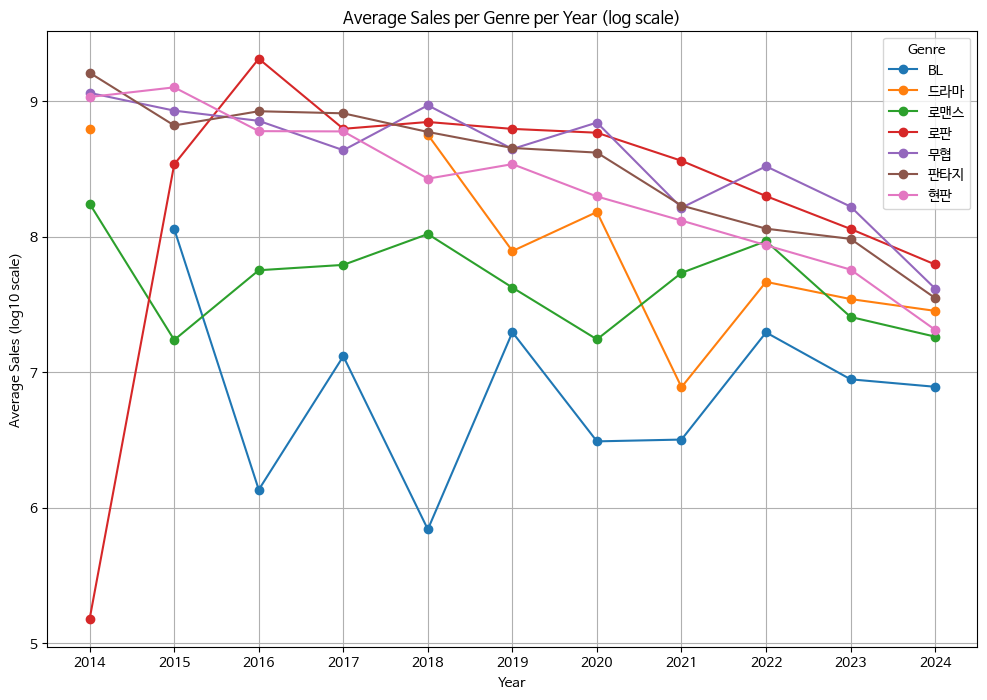

In [23]:


# 날짜를 datetime 형식으로 변환하고 연도 컬럼 추가
kakao['date'] = pd.to_datetime(kakao['date'])
kakao['year'] = kakao['date'].dt.year

# 2014년부터 2024년까지의 데이터만 필터링
kakao = kakao[(kakao['year'] >= 2014) & (kakao['year'] <= 2024)]

# 연도별 장르별 평균 수익 계산
average_sales_per_genre_year = kakao.groupby(['year', 'genre'])['sales'].mean().unstack()

# 로그 스케일 적용
average_sales_per_genre_year_log = np.log10(average_sales_per_genre_year)

# 그래프 그리기
plt.figure(figsize=(12, 8))

for genre in kakao['genre'].unique():
    plt.plot(average_sales_per_genre_year.index, average_sales_per_genre_year_log[genre], marker='o', label=genre)

plt.xlabel('Year')
plt.ylabel('Average Sales (log10 scale)')
plt.title('Average Sales per Genre per Year (log scale)')
plt.legend(title='Genre')
plt.grid(True)
plt.xticks(range(2014, 2025))
plt.show()